
[Nuvem] Inicializada...

[Nuvem] Verificando modelo inicial...

[Nuvem] Nenhum modelo inicial salvo encontrado. Inicializando com valores padrões...

[Nuvem] Conectando aos servidores...
[Nuvem] Conectado ao Servidor 1!
[Nuvem] Enviando modelo global inicial para o servidor 1...
[Nuvem] Modelo global inicial enviado para o servidor 1 com sucesso!
[Nuvem] Conectado ao Servidor 2!
[Nuvem] Enviando modelo global inicial para o servidor 2...
[Nuvem] Modelo global inicial enviado para o servidor 2 com sucesso!
[Nuvem] Conectado ao Servidor 3!
[Nuvem] Enviando modelo global inicial para o servidor 3...
[Nuvem] Modelo global inicial enviado para o servidor 3 com sucesso!

[Nuvem] Iniciando rodada 1 de aprendizado federado
[Nuvem] Aguardando conexão dos servidores...
[Nuvem] Servidor 1 conectado: ('127.0.0.1', 53441)!
[Nuvem] Modelo intermediário recebido do Servidor 1!
[Nuvem] Servidor 2 conectado: ('127.0.0.1', 65292)!
[Nuvem] Modelo intermediário recebido do Servidor 2!
[Nuvem] Servidor 3 

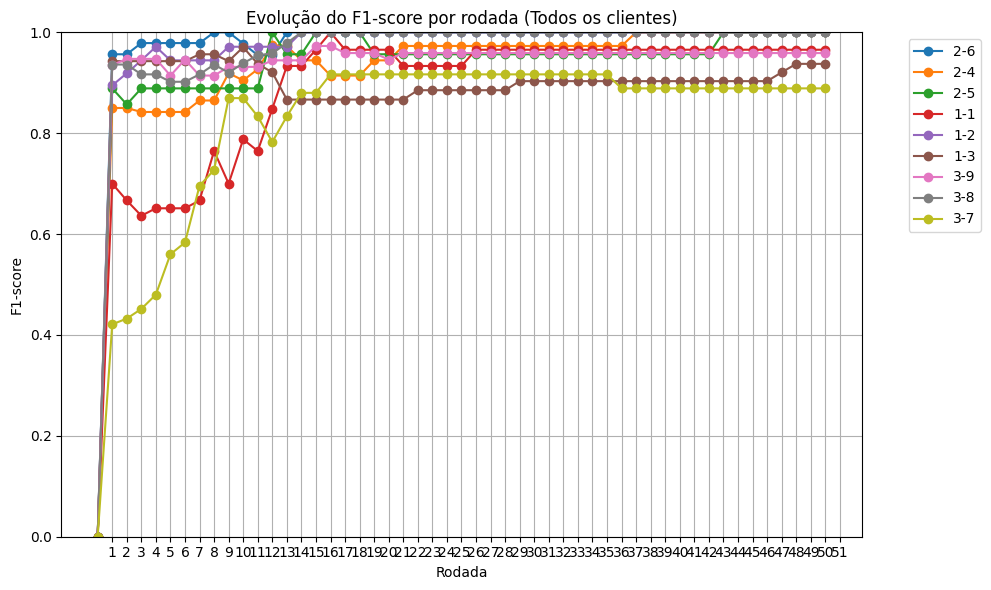

In [1]:
import socket
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

HOSPITAL_HOST = 'localhost'
HOSPITAL_PORT_SEND = 6001  # Porta para enviar modelo global
HOSPITAL_PORT_RECV = 6000  # Porta para receber modelos dos hospitais

NUM_HOSPITALS = 3 # Quantidade de servidores de hopsitais esperados
NUM_ROUNDS = 50 # Quantidade de rodadas de treinamento federado

def receive_hospital_parameters(conn):
    data = b""
    while True:
        packet = conn.recv(HOSPITAL_PORT_RECV)
        if not packet:
            break
        data += packet

    decoded = json.loads(data.decode('utf-8'))
    coef = [np.array(layer) for layer in decoded['coef']]
    intercept = [np.array(b) for b in decoded['intercept']]
    data_size = int(decoded['data_size'])

    return coef, intercept, data_size

# Criar modelo MLP
global_model = MLPClassifier(
    hidden_layer_sizes=(200, 100, 50, 25), # Tupla definindo o número de neurônios em cada camada oculta. Aqui, 4 camadas ocultas com tamanhos variados
    activation='tanh',                     # Função de ativação usada nos neurônios 
    solver='adam',                         # Algoritmo de otimização usado para ajustar pesos (adam = Estimativa Adaptativa de Momentos).
    learning_rate_init=0.005,              # Taxa de aprendizado inicial para o otimizador (quanto maior, mais rápido o ajuste, mas pode ser instável).
    alpha=0.001,                           # Parâmetro de regularização L2 para evitar overfitting (penaliza pesos grandes).  
    max_iter=1,                            # Número máximo de iterações (epochs) por chamada de fit.
    warm_start=True,                       # Permite continuar o treinamento a partir do estado anterior (importante para treino incremental).
    n_iter_no_change=10,                   # Número de iterações sem melhora para parar o treino (não muito usado aqui, pois max_iter=1).
    random_state=42                        # Semente para reprodutibilidade dos resultados(fixa pesos iniciais e shuffling)
)

global_coef = None
global_intercept = None

print("\n[Nuvem] Inicializada...")

print("\n[Nuvem] Verificando modelo inicial...")

MODEL_FILE = 'Modelo_Federado_MLP.json'

if os.path.exists(MODEL_FILE):
    print("\n[Nuvem] Carregando modelo inicial de arquivo existente...")
    with open(MODEL_FILE, 'r') as f:
        model_data = json.load(f)
        initial_coef = [np.array(layer) for layer in model_data['coef']]
        initial_intercept = [np.array(b) for b in model_data['intercept']]
else:
    print("\n[Nuvem] Nenhum modelo inicial salvo encontrado. Inicializando com valores padrões...")
    # Dados fictícios para inicializar pesos
    X_fake = np.zeros((2, 5))      # 2 amostras, 5 features
    y_fake = np.array([0, 1])      # duas classes (0 e 1)

    # Chamada inicial para criar pesos e estruturas internas
    global_model.partial_fit(X_fake, y_fake, classes=[0, 1])
    initial_coef = global_model.coefs_
    initial_intercept = global_model.intercepts_

initial_model_data = {
    "coef": [layer.tolist() for layer in initial_coef],
    "intercept": [b.tolist() for b in initial_intercept],
    "num_rounds" : int(NUM_ROUNDS),
    "params": {
        "hidden_layer_sizes": global_model.hidden_layer_sizes,
        "activation": global_model.activation,
        "solver": global_model.solver,
        "learning_rate_init": global_model.learning_rate_init,
        "alpha": global_model.alpha,
        "max_iter": global_model.max_iter,
        "warm_start": global_model.warm_start,
        "n_iter_no_change": global_model.n_iter_no_change,
        "random_state": global_model.random_state
    }
}

data = json.dumps(initial_model_data).encode('utf-8')

print("\n[Nuvem] Conectando aos servidores...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((HOSPITAL_HOST, HOSPITAL_PORT_SEND))
    s.listen(NUM_HOSPITALS)

    for i in range(NUM_HOSPITALS):
        conn, addr = s.accept()
        with conn:
            print(f"[Nuvem] Conectado ao Servidor {i+1}!")
            print(f"[Nuvem] Enviando modelo global inicial para o servidor {i+1}...")
            conn.sendall(data)
            print(f"[Nuvem] Modelo global inicial enviado para o servidor {i+1} com sucesso!")

for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n[Nuvem] Iniciando rodada {round_num} de aprendizado federado")

    hospital_weights = []
    hospital_sizes = []

    # Receber modelo intermediário dos servidores dos hospitais
    print(f"[Nuvem] Aguardando conexão dos servidores...")
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOSPITAL_HOST, HOSPITAL_PORT_RECV))
        s.listen(NUM_HOSPITALS)

        for i in range(NUM_HOSPITALS):
            conn, addr = s.accept()
            with conn:
                print(f"[Nuvem] Servidor {i+1} conectado: {addr}!")
                hospital_coef, hospital_intercept, data_size = receive_hospital_parameters(conn)

                if not (isinstance(hospital_coef, list) and all(isinstance(layer, np.ndarray) for layer in hospital_coef) and
                    isinstance(hospital_intercept, list) and all(isinstance(b, np.ndarray) for b in hospital_intercept) and
                    isinstance(data_size, int)):
                    raise ValueError("Dados recebidos do Servidor estão em formato incorreto.")

                hospital_weights.append((hospital_coef, hospital_intercept))
                hospital_sizes.append(data_size)

                print(f"[Nuvem] Modelo intermediário recebido do Servidor {i+1}!")

    # Inicializa os acumuladores se for a primeira rodada
    if global_coef is None:
        # Inicializa uma lista de arrays, um para cada camada
        global_coef = [np.zeros_like(layer) for layer in hospital_weights[0][0]]
        global_intercept = [np.zeros_like(bias) for bias in hospital_weights[0][1]]
    else:
        # Zera os valores das camadas
        for i in range(len(global_coef)):
            global_coef[i].fill(0)
            global_intercept[i].fill(0)

    total_data_size = sum(hospital_sizes)
    if total_data_size == 0:
        raise ValueError("Tamanho total dos dados dos Servidores é zero.")

    # Realização do FedAvg(Agregação por média)
    # Coef e Intercept são os parâmetros utilizados no modelo
    # - Coef(Coeficiente): Representa os pesos atribuídos a cada atributo (feature) do modelo. É um vetor ou matriz (dependendo da tarefa) que determina quanto cada variável influencia a predição.
    # - Intercept(Intercepto): É o termo de bias, o valor que o modelo usa quando todas as entradas são zero. Serve para ajustar o ponto de corte (threshold) da função de decisão.
    print(f"[Nuvem] Realizando FedAvg do modelo global...")
    for i in range(NUM_HOSPITALS):
        weight = hospital_sizes[i] / total_data_size
        local_coef, local_intercept = hospital_weights[i]

        for j in range(len(global_coef)):
            global_coef[j] += local_coef[j] * weight
            global_intercept[j] += local_intercept[j] * weight    

    # Atualizar modelo global
    global_model.coefs_ = global_coef
    global_model.intercepts_ = global_intercept

    print(f"[Nuvem] Modelo global atualizado na rodada {round_num}!")

    # Enviar modelo global para os servidores dos hospitais
    print(f"[Nuvem] Enviando modelo global para os servidores...")
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOSPITAL_HOST, HOSPITAL_PORT_SEND))
        s.listen(NUM_HOSPITALS)

        for i in range(NUM_HOSPITALS):
            conn, addr = s.accept()
            with conn:
                print(f"[Nuvem] servidor {i+1} conectado: {addr}!")
                global_model_data = {
                    "coef": [layer.tolist() for layer in global_coef],
                    "intercept": [b.tolist() for b in global_intercept],
                }
                data = json.dumps(global_model_data).encode('utf-8')
                print(f"[Nuvem] Enviando modelo global para o servidor {i+1}...")
                conn.sendall(data)
                print(f"[Nuvem] Modelo global enviado para o servidor {i+1}!")

print("\n[Nuvem] Todas as rodadas de treinamento federado foram concluídas!")

# Salvar modelo global final em arquivo JSON
print(f"\n[Nuvem] Salvando modelo global final...")
final_model_data = {
    "class": global_model.__class__.__name__,
    "params": global_model.get_params(),
    "coef": [layer.tolist() for layer in global_coef],
    "intercept": [b.tolist() for b in global_intercept],
}
with open(MODEL_FILE, 'w') as f:
    json.dump(final_model_data, f)
print(f"[Nuvem] Modelo global salvo em '{MODEL_FILE}'.")

# Receber f1 dos servidores dos hospitais
all_f1_servers = {}  # dicionário para armazenar F1 por cliente
print(f"\n[Nuvem] Aguardando conexão dos servidores...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOSPITAL_HOST, HOSPITAL_PORT_RECV))
    s.listen(NUM_HOSPITALS)

    for i in range(NUM_HOSPITALS):
        conn, addr = s.accept()
        with conn:
            print(f"[Nuvem] Servidor {i+1} conectado: {addr}!")
            
            # Recebe os dados
            data = b""
            while True:
                packet = conn.recv(4096)  # buffer
                if not packet:
                    break
                data += packet

            # Desserializa o JSON
            received = json.loads(data.decode("utf-8"))
            server_id = received["id"]
            f1_per_round = received["f1"]

            # Salva no dicionário principal
            all_f1_servers[server_id] = f1_per_round

        print(f"[Nuvem] Recebido F1 dos clientes do Servidor {i+1} com sucesso!")

final_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

# Receber métricas do modelo intermediário dos servidores dos hospitais
print(f"\n[Nuvem] Aguardando conexão dos servidores...")
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOSPITAL_HOST, HOSPITAL_PORT_RECV))
    s.listen(NUM_HOSPITALS)

    for i in range(NUM_HOSPITALS):
        conn, addr = s.accept()
        with conn:
            print(f"[Nuvem] Servidor {i+1} conectado: {addr}!")
            data = conn.recv(HOSPITAL_PORT_RECV)
            metrics = json.loads(data.decode('utf-8'))
            for key in final_metrics:
                final_metrics[key].append(metrics[key])
print(f"[Nuvem] Métricas do modelo intermediário recebidas do Servidor {i+1} com sucesso!")


# Média final global
print(f"\n[Nuvem] Realizando média final global das métricas de desempenho do modelo...")
global_avg = {k: np.mean(v) for k, v in final_metrics.items()}

# Exibir resultado
print("[Nuvem] Avaliação Global final do Modelo Federado:")
for metric, value in global_avg.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Exibindo gráfico da evolução do f1 de cada cliente
plt.figure(figsize=(10,6))

for server_id, f1_dict in all_f1_servers.items():
    for client_id, f1_list in f1_dict.items():
        # Converte string para lista se necessário
        if isinstance(f1_list, str):
            import ast
            f1_list = ast.literal_eval(f1_list)
        plt.plot(range(len(f1_list)), f1_list, marker='o', label=f"{server_id}-{client_id}")

plt.xlabel("Rodada")
plt.ylabel("F1-score")
plt.title("Evolução do F1-score por rodada (Todos os clientes)")
plt.xticks(range(1, len(f1_list)+1))
plt.ylim(0,1)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Interpretação das métricas de desempenho do modelo global

Ajustes feitos que melhoraram o modelo:
* Ajustado o tamanho do dado de treino enviado de cada cliente, pois antes estava sendo enviado após o smote e acabava inflando o peso deles com dados sintéticos;
* 50 rodadas parece ser o ideal para o treinamento do modelo, comparando os resultados;
* Não validar o F1 para ajustar o threshold, melhora o desempenho pois não deixa ele congelado em um valor que funcionava bem em rodadas anteriores, mas que já não é o ótimo para o modelo atualizado.

Interpretação dos resultados:
* Accuracy
  * Centralizado: 0.9855
  * Federado: 0.9839
    * Diferença: −0.0016 (0.16 ponto percentual), praticamente igual, diferença irrelevante estatisticamente.
  
* Precision (proporção de acertos entre os positivos preditos)
  * Centralizado: 1.0000 (nenhum falso positivo)
  * Federado: 0.9778 (poucos falsos positivos)
    * Diferença: −0.0222 (~2.2 p.p.). O centralizado está mais “cauteloso” e não errou positivos, enquanto o federado errou muito pouco.

* Recall (capacidade de encontrar todos os positivos)
  * Centralizado: 0.9500
  * Federado: 0.9707
    * Diferença: +0.0207 (~2.1 p.p.). O federado encontra mais casos positivos, ou seja, menos falsos negativos.
   
* F1-score (harmonia entre precisão e recall)
  * Centralizado: 0.9700
  * Federado: 0.9723
    * Diferença: +0.0023 (0.23 p.p.). Empate técnico, com leve vantagem para o federado.
   
Interpretação geral:
* Centralizado: Máxima precisão (zero falsos positivos), mas sacrifica um pouco o recall (deixa escapar alguns casos positivos).
* Federado: Levemente menos preciso, mas detecta mais positivos (maior recall), o que elevou seu F1 acima do centralizado.

O federado está melhor em detectar o máximo de casos positivos, o que é muito bom para área da saúde e na detecção de doenças cardíacas.